In [2]:
import cv2
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

from pipeline import stack,meso,collection,experiment

import datajoint as dj
import static_nda as nda



Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [37]:
# Erick: Utility I found online to make sure axes have the same aspect ratio

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# Get Stacks 

In [44]:
dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys_filtered.npy', allow_pickle=True)
stack_candidate_keys = [{k:v for k,v in zip(('animal_id','session','stack_idx'),d['stack'].split('-'))} for d in dics]
post_loss_sessions = experiment.Session.proj(datediff='DATEDIFF(session_date,"2020-02-08")') & 'datediff>0'

# for stack_key in stack.PreprocessedStack & stack_candidate_keys & post_loss_sessions
stack_key = np.random.choice((stack.PreprocessedStack & stack_candidate_keys & post_loss_sessions).fetch('KEY'))
stack_key['stack_session'] = stack_key['session']

g_stack = (stack.PreprocessedStack & stack_key).fetch1('resized')
x,y,z = (stack.CorrectedStack & stack_key).fetch1('x','y','z')


In [45]:
print(stack_key)

{'animal_id': 23656, 'session': 14, 'stack_idx': 18, 'volume_id': 1, 'channel': 1, 'stack_session': 14}


# Transform

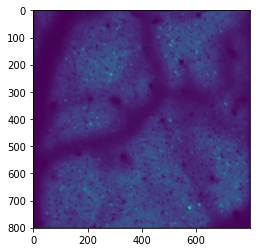

In [46]:
plt.imshow(g_stack[0])

In [47]:
# TRANSPOSE and FLIP in order to move into M to L left to right, P to A back to front
# g_stack_mod = np.flip(g_stack.transpose([0,2,1]),axis=(1,2))

# FLIP in order to move into A to P left to right, L to M back to front 
g_stack_mod = np.flip(g_stack,axis=(2))

# Reshape Stack and Get Photogenic Edges

In [48]:
# tweak to modify scope and photogenic boundaries
d_min,d_max = 50,95
y_min,y_max = 86,802-86
x_min,x_max = 99,829-100

# tweak to rescale intensity to capture most interesting dynamic range
p_min = 0.1
p_max = 99.9

# create images full of nans
ims = [np.full((y_max-y_min,x_max-x_min,3),np.nan),
       np.full((d_max-d_min,x_max-x_min,3),np.nan),
       np.full((d_max-d_min,y_max-y_min,3),np.nan)]

# replace green layers in rgb images with data normalized to 0 - 1 range
planes = [g_stack_mod[d_min,       y_min:y_max, x_min:x_max],  #above
          g_stack_mod[d_min:d_max, y_max,       x_min:x_max],  #front
          g_stack_mod[d_min:d_max, y_min:y_max, x_max]]        #side

int_min = np.min([np.percentile(p,p_min) for p in planes])
int_max = np.max([np.percentile(p,p_max) for p in planes])

planes = [np.clip((p-int_min)/(int_max-int_min),0,1) for p in planes]

for im,p in zip(ims,planes):
    im[:,:,1] = p

# Test Plot Images (faster than 3D)

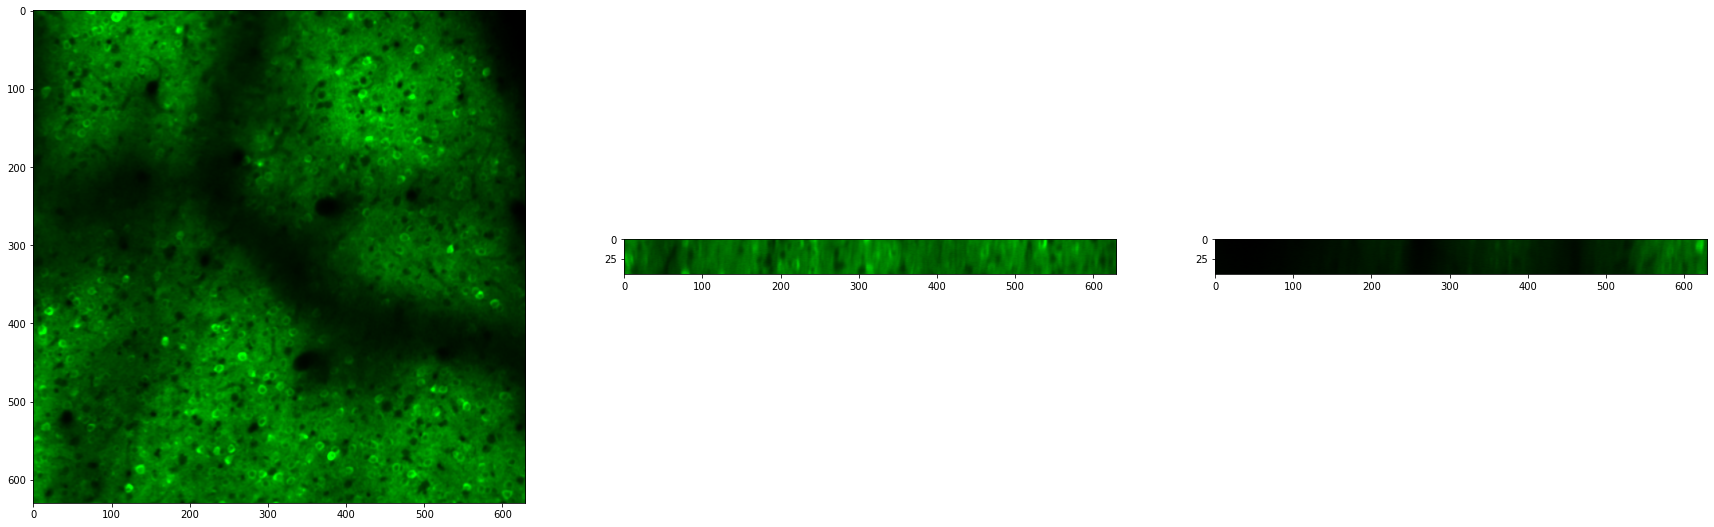

In [49]:
fig,axes = plt.subplots(1,3,figsize=(30,10))

for ax,im in zip(axes,ims):
    ax.imshow(im)
    ax.set_aspect('equal')

# Plot in 3D (quite slow at full res)


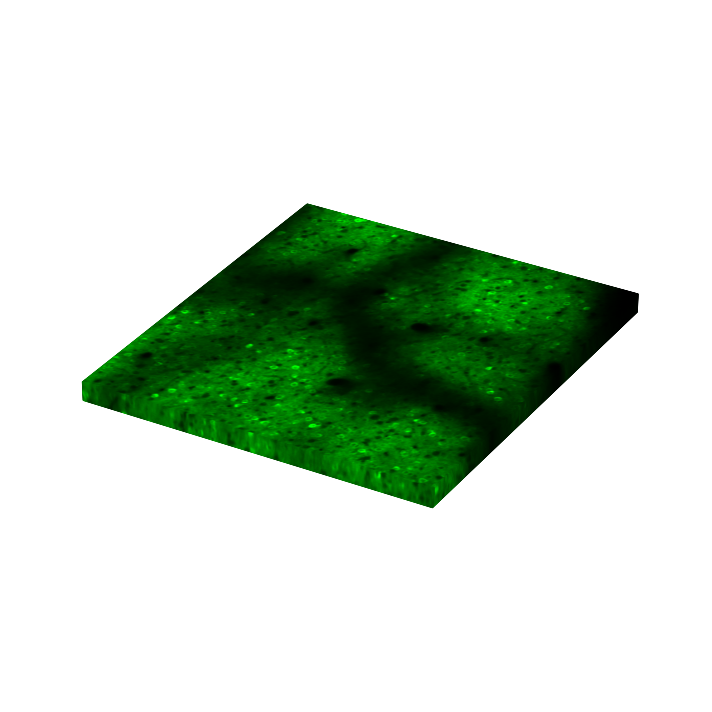

In [50]:
# new, centered dimensions (poorly named, should be better handled here)
xlen = x_max-x_min
ylen = y_max-y_min
zlen = d_max-d_min

# zmin, zmax = z - zlen / 2, z + zlen / 2
# ymin, ymax = y - ylen / 2, y + ylen / 2
# xmin, xmax = x - xlen / 2, x + xlen / 2

zmin, zmax = -zlen / 2, zlen / 2
ymin, ymax = -ylen / 2, ylen / 2
xmin, xmax = -xlen / 2, xlen / 2


# take larger pixel strides to test plot faster, final plot at 1 px stride
rstride,cstride = 1,1

# make 3d axis
fig = plt.figure(figsize=(10,10),facecolor='none')
ax = fig.gca(projection='3d')

# create meshgrid and plot top (XY) image
X, Y = np.meshgrid(np.linspace(xmin, xmax, xlen), np.linspace(ymin, ymax, ylen))
ax.plot_surface(X, Y, np.full_like(X,zmin), rstride=rstride, cstride=cstride, facecolors=ims[0], shade=False)

# create meshgrid and plot left face (XZ)
X, Z = np.meshgrid(np.linspace(xmin, xmax, xlen), np.linspace(zmin, zmax, zlen))
ax.plot_surface(X, np.full_like(X,ymax), Z, rstride=rstride, cstride=cstride, facecolors=ims[1], shade=False)

# create meshgrid and plot right face (YZ)
Y, Z = np.meshgrid(np.linspace(ymin, ymax, ylen), np.linspace(zmin, zmax, zlen))
ax.plot_surface(np.full_like(Y,xmax), Y, Z, rstride=rstride, cstride=cstride, facecolors=ims[2], shade=False)

# set axis equal so 1 px equal size in all dimensions
set_axes_equal(ax)

# flip y and z axis (turn axis on to see)
ax.invert_zaxis()
ax.set_ylim(ymax+1,ymin-1) #invert_yaxis bugged in matplotlib 3d
ax.axis('off') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_facecolor('none')
fig.tight_layout()
# title = str(animal_key['animal_id']) + '_stack_block.png'

# plt.savefig('two_photon_volume.png', dpi=300, facecolor='none')
plt.show()


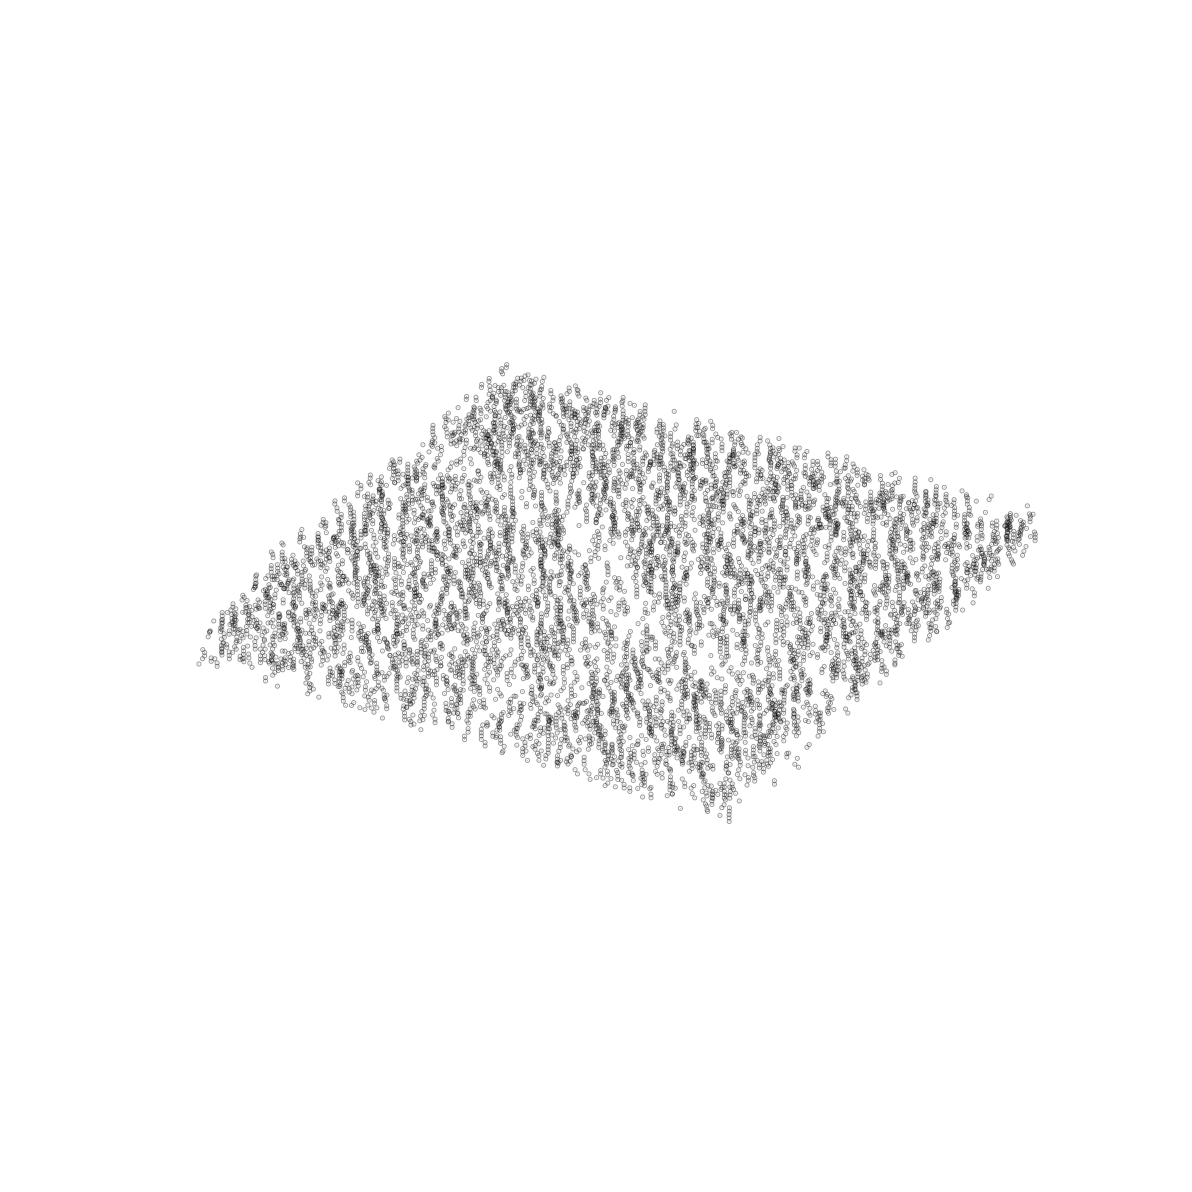

In [51]:
xs,ys,zs = (meso.StackCoordinates.UnitInfo & (nda.Scan & stack_key) & stack_key).fetch('stack_x','stack_y','stack_z')
xs,ys,zs = [c-np.mean(c) for c in (xs,ys,zs)]
# xs,ys,zs,areas = (((nda.StackUnit & nda.ScanInclude) & nda.Oracle) * nda.AreaMembership).fetch('np_x','np_y','np_z','brain_area')

fig = plt.figure(figsize=(5,5),dpi=300)
ax = plt.gca(projection='3d')

ax.scatter(xs,ys,zs,'o',
           facecolor='k', alpha=0.4,s=.05,
           edgecolor='k')
set_axes_equal(ax)
ax.invert_yaxis()
ax.invert_xaxis()
ax.invert_zaxis()
ax.set_axis_off()

# Imaging Volume, Discrete Representation

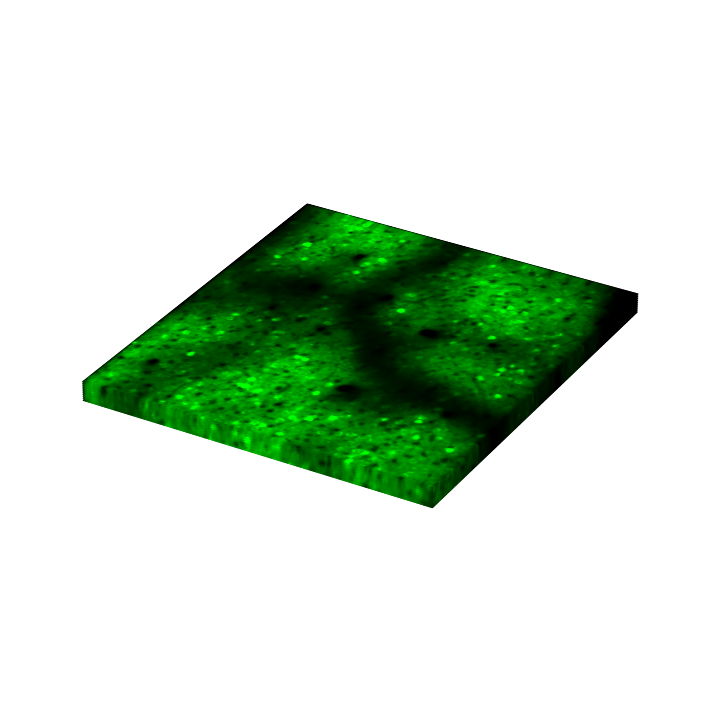

In [48]:
scan = (nda.Scan & {'animal_id':23656}).fetch1('KEY')
dim_strs = ['px_width','px_height','um_width','um_height']
pw,ph,uw,uh = (dj.U(*dim_strs) & (meso.ScanInfo.Field & scan)).fetch1(*dim_strs)
zs,ims = ((meso.ScanInfo.Field & scan) * meso.SummaryImages.Average).fetch('z','average_image',order_by='z ASC')
fig = plt.figure(figsize=(10,10),facecolor='none')
ax = plt.gca(projection='3d')

vmin = np.nanpercentile(np.hstack(ims),1)
vmax = np.nanpercentile(np.hstack(ims),99)
    
rstride,cstride=1,1

for z, im in zip(zs,ims):
    plt_im = np.zeros((w,h,3))
    plt_im[:,:,1] = np.flip(im,axis=(1))
    plt_im -= vmin
    plt_im /= vmax
    plt_im = np.clip(plt_im,0,1)

    # create meshgrid and plot top (XY) image per scan field
    X, Y = np.meshgrid(np.linspace(-uw/2,uw/2,pw), np.linspace(-uh/2,uh/2,ph))
    ax.plot_surface(X,Y,np.full_like(X,z),rstride=rstride,cstride=cstride,facecolors=plt_im,shade=False)
    
# set axis equal so 1 px equal size in all dimensions
set_axes_equal(ax)

# flip y and z axis (turn axis on to see)
ax.invert_zaxis()
ax.set_ylim(uh/2+1,-uh/2-1) #invert_yaxis bugged in matplotlib 3d
ax.axis('off') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_facecolor('none')
fig.tight_layout()
# title = str(animal_key['animal_id']) + '_stack_block.png'

# plt.savefig('two_photon_volume.png', dpi=300, facecolor='none')
plt.show()
